### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
# Edited by Riley Estes
# Performance testing by Riley Estes
# EE399 HW6
# 5/20/2023
# https://github.com/rileywe/Pyshred-Performances


import numpy as np
from processdata import load_data, TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from processdata import load_full_SST

### Load data and initialize default values
num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


We now select indices to divide the data into training, validation, and test sets.

In [2]:
### Generate a dataset given lags
def genData(lags):
  train_indices = np.random.choice(n - lags, size=1000, replace=False)
  mask = np.ones(n - lags)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2]
  return train_indices, valid_indices, test_indices

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [3]:
### Preprocess the data given parameters
def preprocess(lags=lags, num_sensors=num_sensors, noise_stdev=0.0):
  sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
  train_indices, valid_indices, test_indices = genData(lags)
  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - lags, lags, num_sensors))
  for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

  ### Add random Gaussian noise to the data
  noise = np.random.normal(0, noise_stdev, all_data_in.shape)
  all_data_in += noise

  ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
  train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
  
  return train_dataset, valid_dataset, test_dataset, test_indices, sc

In [5]:
### Train and test the model
def run_model(train_dataset, valid_dataset, test_dataset, sc, sensors=num_sensors):  
  shred = models.SHRED(sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
  return test_recons, error

In [4]:
### Plot the ground truth map and the model-generated map
def plot(test_indices, test_recons, title):
  # SST data with world map indices for plotting
  full_SST, sst_locs = load_full_SST()
  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  # reshaping to 2d frames
  for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

  plotdata = [full_test_truth, full_test_recon]
  labels = ['truth','recon']
  fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
  for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.set_title(title)
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

In [6]:
train_dataset, valid_dataset, test_dataset, test_indices, sc = preprocess()

We train the model using the training and validation datasets.

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [7]:
test_recons, error = run_model(train_dataset, valid_dataset, test_dataset, sc)
print("Accuracy = {:.2%}".format((1 - error)))

epoch: 900 valid_error: tensor(0.1075, device='cuda:0'):  90%|████████▉ | 899/1000 [03:19<00:22,  4.51it/s]

Accuracy = 98.03%


Plot a sample test frame and its reconstruction.

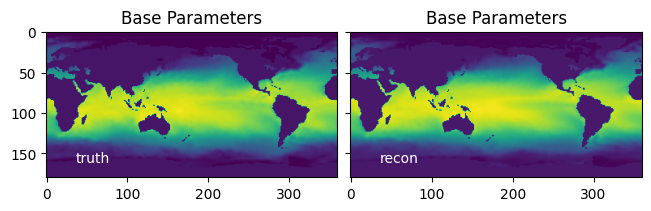

In [8]:
plot(test_indices, test_recons, "Base Parameters")

Training with lag = 1


epoch: 460 valid_error: tensor(0.2438, device='cuda:0'):  46%|████▌     | 459/1000 [01:36<01:53,  4.77it/s]


Accuracy when lag is 1: 95.36%

Training with lag = 26


epoch: 1000 valid_error: tensor(0.1130, device='cuda:0'): 100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


Accuracy when lag is 26: 97.98%

Training with lag = 47


epoch: 740 valid_error: tensor(0.1128, device='cuda:0'):  74%|███████▍  | 739/1000 [02:47<00:59,  4.42it/s]


Accuracy when lag is 47: 97.99%

Training with lag = 52


epoch: 1000 valid_error: tensor(0.1082, device='cuda:0'): 100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


Accuracy when lag is 52: 98.05%

Training with lag = 57


epoch: 880 valid_error: tensor(0.1097, device='cuda:0'):  88%|████████▊ | 879/1000 [03:17<00:27,  4.45it/s]


Accuracy when lag is 57: 98.01%

Training with lag = 78


epoch: 760 valid_error: tensor(0.1104, device='cuda:0'):  76%|███████▌  | 759/1000 [02:58<00:56,  4.25it/s]


Accuracy when lag is 78: 98.01%

Training with lag = 104


epoch: 820 valid_error: tensor(0.1093, device='cuda:0'):  82%|████████▏ | 819/1000 [03:18<00:43,  4.12it/s]


Accuracy when lag is 104: 98.01%



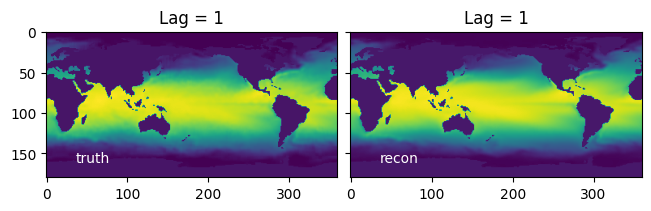

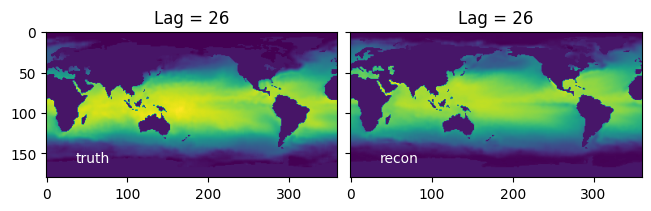

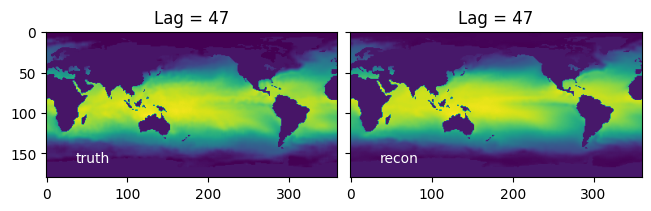

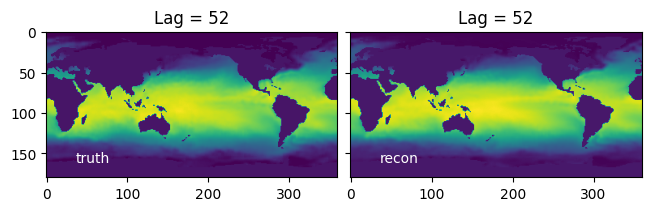

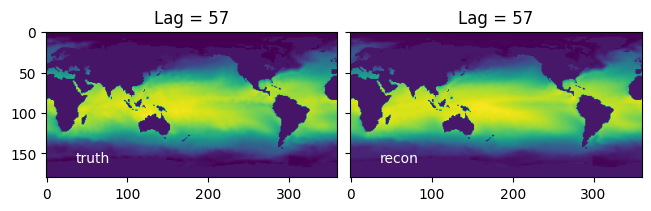

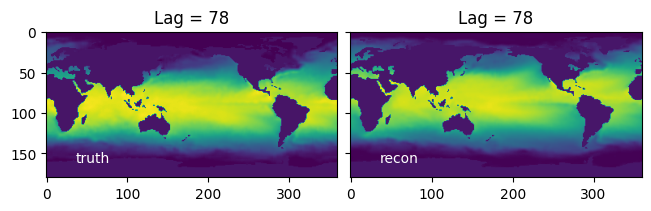

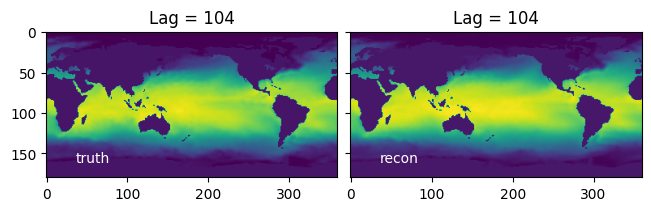

In [9]:
### Test the model by sweeping through different lags
lag_list = [1, 26, 47, 52, 57, 78, 104]
performances_lag = []
for lag in lag_list:
  print("Training with lag = {}".format(lag))
  train_dataset, valid_dataset, test_dataset, test_indices, sc = preprocess(lags=lag)
  test_recons, error = run_model(train_dataset, valid_dataset, test_dataset, sc)
  plot(test_indices, test_recons, "Lag = {}".format(lag))
  print("Accuracy when lag is {}: {:.2%}".format(lag, (1 - error)))
  performances_lag.append((1 - error))
  print()

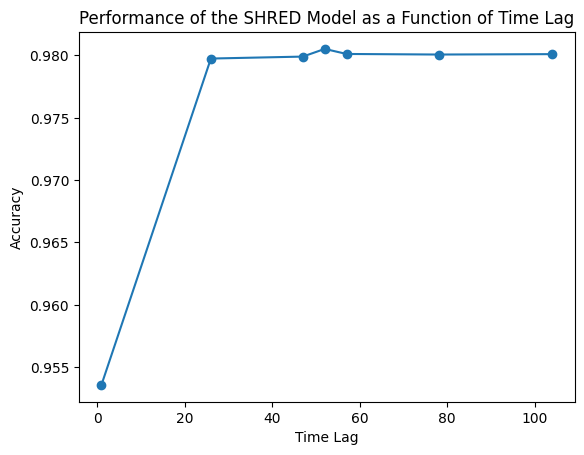

In [10]:
plt.plot(lag_list, performances_lag, marker='o')
plt.xlabel('Time Lag')
plt.ylabel('Accuracy')
plt.title('Performance of the SHRED Model as a Function of Time Lag')
plt.show()

Training with 0.0 standard deviation of added Gaussian noise


epoch: 1000 valid_error: tensor(0.1091, device='cuda:0'): 100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


Accuracy when noise stdev is 0.0: 98.01%

Training with 0.1 standard deviation of added Gaussian noise


epoch: 1000 valid_error: tensor(0.1350, device='cuda:0'): 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


Accuracy when noise stdev is 0.1: 97.68%

Training with 0.25 standard deviation of added Gaussian noise


epoch: 320 valid_error: tensor(0.2169, device='cuda:0'):  32%|███▏      | 319/1000 [01:07<02:24,  4.71it/s]


Accuracy when noise stdev is 0.25: 96.19%

Training with 0.5 standard deviation of added Gaussian noise


epoch: 240 valid_error: tensor(0.2411, device='cuda:0'):  24%|██▍       | 239/1000 [00:51<02:43,  4.66it/s]


Accuracy when noise stdev is 0.5: 95.52%

Training with 0.75 standard deviation of added Gaussian noise


epoch: 120 valid_error: tensor(0.2685, device='cuda:0'):  12%|█▏        | 119/1000 [00:27<03:22,  4.35it/s]


Accuracy when noise stdev is 0.75: 94.50%

Training with 1.0 standard deviation of added Gaussian noise


epoch: 140 valid_error: tensor(0.3261, device='cuda:0'):  14%|█▍        | 139/1000 [00:31<03:14,  4.42it/s]


Accuracy when noise stdev is 1.0: 93.36%

Training with 2.0 standard deviation of added Gaussian noise


epoch: 120 valid_error: tensor(0.4908, device='cuda:0'):  12%|█▏        | 119/1000 [00:27<03:24,  4.32it/s]


Accuracy when noise stdev is 2.0: 89.34%



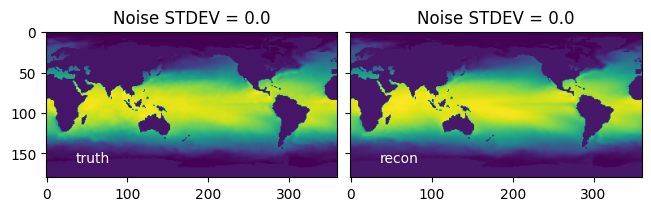

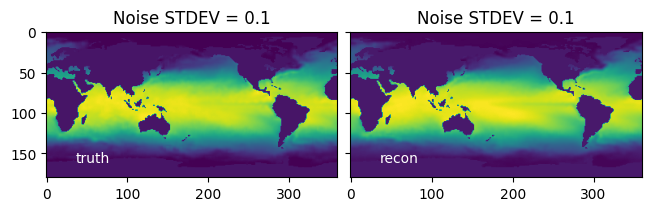

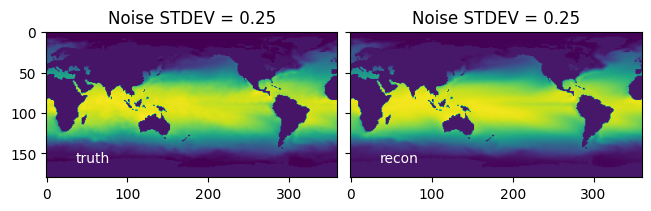

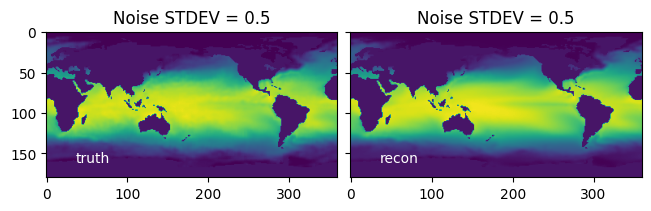

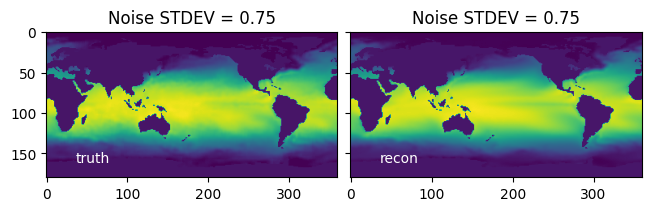

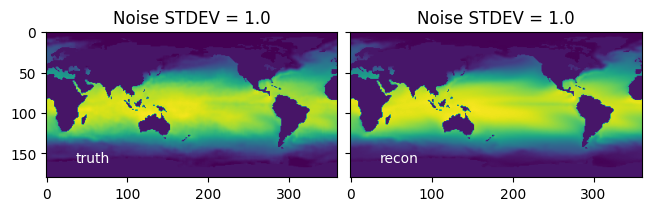

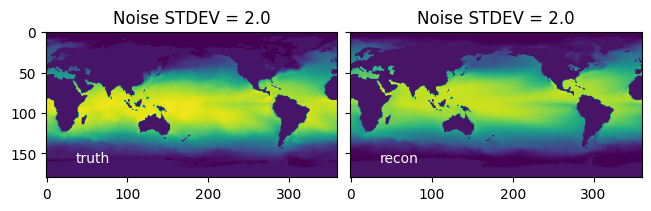

In [16]:
### Test the model by sweeping through different noise levels
noise_standard_deviations = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0]
performances_noise = []
for noise_standard_deviation in noise_standard_deviations:
  print("Training with {} standard deviation of added Gaussian noise".format(noise_standard_deviation))
  train_dataset, valid_dataset, test_dataset, test_indices, sc = preprocess(noise_stdev=noise_standard_deviation)
  test_recons, error = run_model(train_dataset, valid_dataset, test_dataset, sc)
  plot(test_indices, test_recons, "Noise STDEV = {}".format(noise_standard_deviation))
  print("Accuracy when noise stdev is {}: {:.2%}".format(noise_standard_deviation, (1 - error)))
  performances_noise.append((1 - error))
  print()

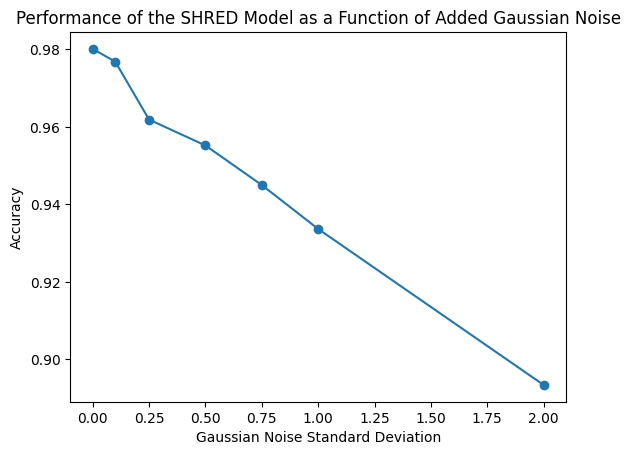

In [17]:
plt.plot(noise_standard_deviations, performances_noise, marker='o')
plt.xlabel('Gaussian Noise Standard Deviation')
plt.ylabel('Accuracy')
plt.title('Performance of the SHRED Model as a Function of Added Gaussian Noise')
plt.show()

Training with 1 sensors


epoch: 900 valid_error: tensor(0.3109, device='cuda:0'):  90%|████████▉ | 899/1000 [03:27<00:23,  4.34it/s]


Accuracy with 2.0 sensors is: 92.95%

Training with 2 sensors


epoch: 740 valid_error: tensor(0.1989, device='cuda:0'):  74%|███████▍  | 739/1000 [02:51<01:00,  4.32it/s]


Accuracy with 2.0 sensors is: 95.88%

Training with 3 sensors


epoch: 960 valid_error: tensor(0.1070, device='cuda:0'):  96%|█████████▌| 959/1000 [03:37<00:09,  4.41it/s]


Accuracy with 2.0 sensors is: 98.05%

Training with 4 sensors


epoch: 1000 valid_error: tensor(0.1094, device='cuda:0'): 100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]


Accuracy with 2.0 sensors is: 98.05%

Training with 5 sensors


epoch: 1000 valid_error: tensor(0.1105, device='cuda:0'): 100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


Accuracy with 2.0 sensors is: 98.02%

Training with 10 sensors


epoch: 700 valid_error: tensor(0.1117, device='cuda:0'):  70%|██████▉   | 699/1000 [02:30<01:04,  4.66it/s]


Accuracy with 2.0 sensors is: 97.98%

Training with 15 sensors


epoch: 1000 valid_error: tensor(0.1145, device='cuda:0'): 100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


Accuracy with 2.0 sensors is: 98.03%



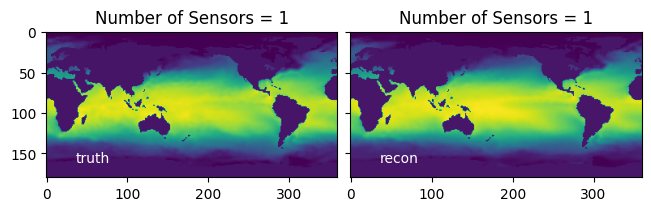

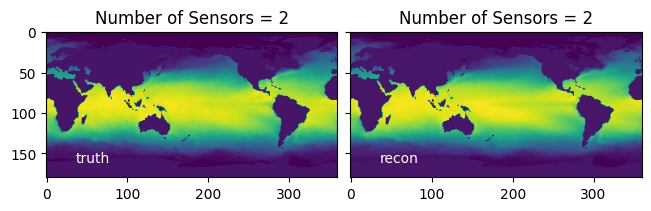

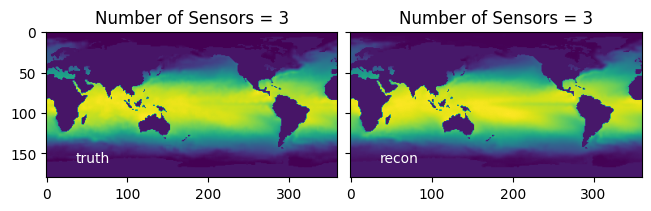

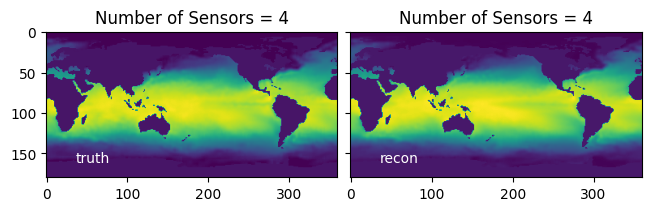

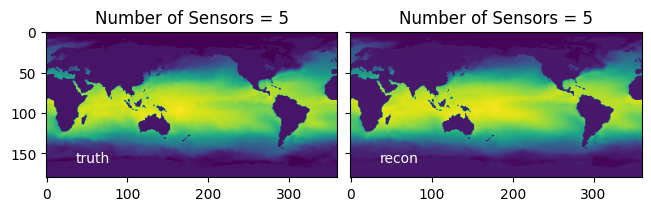

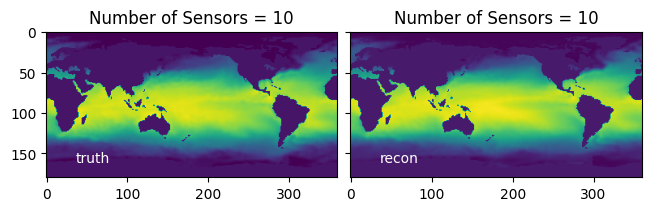

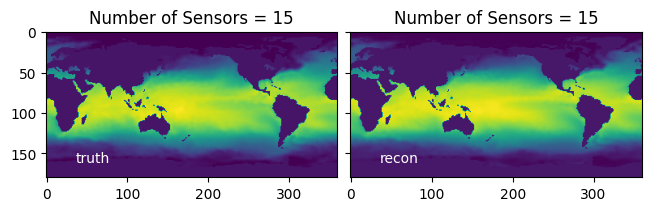

In [13]:
### Test the model by sweeping through different numbers of sensors
sensor_numbers = [1, 2, 3, 4, 5, 10, 15]
performances_sensor = []
for sensors in sensor_numbers:
  print("Training with {} sensors".format(sensors))
  train_dataset, valid_dataset, test_dataset, test_indices, sc = preprocess(num_sensors=sensors)
  test_recons, error = run_model(train_dataset, valid_dataset, test_dataset, sc, sensors=sensors)
  plot(test_indices, test_recons, "Number of Sensors = {}".format(sensors))
  print("Accuracy with {} sensors is: {:.2%}".format(noise_standard_deviation, (1 - error)))
  performances_sensor.append((1 - error))
  print()

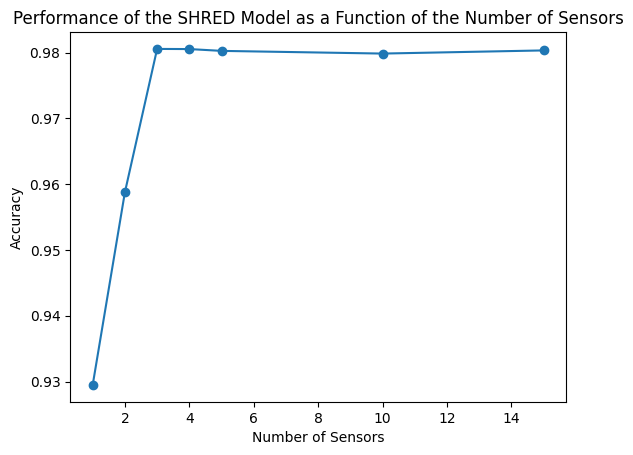

In [15]:
plt.plot(sensor_numbers, performances_sensor, marker='o')
plt.xlabel('Number of Sensors')
plt.ylabel('Accuracy')
plt.title('Performance of the SHRED Model as a Function of the Number of Sensors')
plt.show()